### Задача

Правда ли бикас дает преимущество? Или лучше разгонять без всяких там бикасов

In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from powderlayer import PowderBD, PowderOvLayer, Powder
from gaslayer import GasEOS, GasLayer
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq

#### Простая цилиндрическая пушка

q_max = 0.12166999999999997


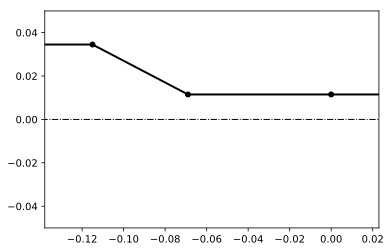

In [5]:
d = 23e-3
C_q_max = 10
q_max = C_q_max * (d*10)**3
print(f'q_max = {q_max}')


tube_dict = {
    'tube_points': [[-d*100,3*d],[-d*5,3*d],[-3*d,d],[0, d], [100*d, d]]
}
tube = Tube.get_standart(tube_dict)
ax, fig = plt.subplots()
tube.plot(ax, fig)
fig.set_ylim(-0.05,0.05)
fig.set_xlim(-6*d,d)
plt.show()

In [6]:
a1 = np.linspace(0,1,5)
a2 = np.linspace(0,1,5)
np.concatenate([a1, a2])

array([0.  , 0.25, 0.5 , 0.75, 1.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

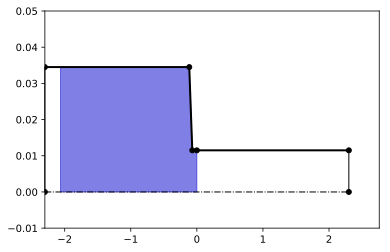

In [14]:
gas_layer_dict = {
        'type': 'gas',
        'name': 'He',
        'gamma': 1.66,
        'kappa': 0.005925,
        'R': 2078,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': 100e6, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': 0
    }
def get_simple_gl(**kwargs):
#     'type': 'gas',
    #     'name': 'He',
    #     'gamma': 1.66,
    #     'kappa': 0.005925,
    #     'R': 2078,

    #     'type': 'gas',
    #     'name': 'Air',
    #     'gamma': 1.4,
    #     'kappa': 0.0010838,
    #     'R': 287,
    

    index_anchor = 100
    calc_settings = {
        'cell_dx': 0.0025,
        'n_cells': 200,
        'n_cells_min': 13,
        'n_cells_max': 200,
        'GasFluxCalculator_kwargs': {'flux_type':2, 'x_order':1},
        'GridStrecher_kwargs': {'strech_type': 3, 'index_anchor':index_anchor}
    } 
    if 'tube' in kwargs:
        tube = kwargs['tube']
    else:
        tube_dict = {
            'tube_points': [[-d*100,3*d],[-d*5,3*d],[-3*d,d],[0, d], [100*d, d]]
        }
        tube = Tube.get_standart(tube_dict)
    
    ro_0 = gas_layer_dict['p_0']/(gas_layer_dict['R']*gas_layer_dict['T_0'] + gas_layer_dict['p_0']*gas_layer_dict['kappa'])
    omega = q_max * 5
    gas_layer_dict['W_0'] = omega / ro_0
    x1 = tube.get_x1(gas_layer_dict['x_2'], gas_layer_dict['W_0'])

    gl = GasLayer.get_standart(tube, x1, gas_layer_dict, calc_settings)   
    xs_bord0 = np.linspace(x1, -10*d, 2*(index_anchor+1)//3)
    xs_bord1 = np.linspace(-10*d, -2*d, (index_anchor+1)-len(xs_bord0)+1)[1:]
    xs_bord2 = np.linspace(-2*d, gas_layer_dict['x_2'], gl.n_cells-index_anchor+1)[1:]
    xs_bord = np.concatenate([xs_bord0, xs_bord1, xs_bord2])
    gl.xs_borders[:] = xs_bord
    gl.init_SsdW()
    gl.init_q()
    gl.init_taus_acustic()
    return gl
gl = get_simple_gl()
fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.01,0.05)
ax.set_xlim(-100*d,120*d)
plt.show()

# gl.xs_borders.shape, xs_board.shape, xs_bord[index_anchor]+2*d, xs_bord[-1]

In [15]:
lrs = [gl]
b = BorderSimple(gl, None, q_max/5, 0)
vl = 0
for i in tqdm_notebook(range(15000)):
    if lrs[-1].xs_borders[-1] > tube.get_xs()[-1]:
        break
    tau = lrs[-1].get_tau_min()*0.4
    b.update_xs()
    b.update_Vs(tau)
    gl = gl.step_up(tau, False)
    lrs.append(gl)
    b.lr_left = gl
    
 

In [16]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=100, value=0))
def plotMe(ind):
    
    lr = lrs[ind]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    tube.plot(fig, ax2)
    ax2.set_ylim(-0.005, 0.09)
    lr.plot(fig, ax2)
    
    param_name = 'us'

    xs = np.array(lr.xs_borders)
    ys = np.array(lr.Vs_borders)
    color = lr.color_4_plot
    lw = 2
    ax0.plot(xs, ys, color=color, label=f'Vs', lw=0, marker='o', ms=0.2)
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    ax0.plot(xs, ys, color=color, lw=lw, label=f'{param_name} газ')

    ax0.grid(True)
    ax0.set_ylabel(param_name)
#     ax0.set_ylim(900,1000)
    ax0.set_title(f't={lr.time*1000} ms; i={ind}')
    ax0.legend()
    
    param_name = 'ps'
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
#     ax1.plot(xs, ys, color=color, lw=lw, label=f'{param_name} газ')
    ax1.plot(xs, lr.get_Ts(gas_layer_dict['R'])-273, color=color, lw=lw, label=f'{param_name} газ')
    
    ax1.grid(True)
    ax1.set_ylabel(f'${param_name}$, ')
#     ax1.set_ylim(-500,700)
#     ax1.set_title(f't={lr.time*1000} ms; i={ind}')
    ax1.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=5334, step=100), Output()), _dom_classes=('wid…

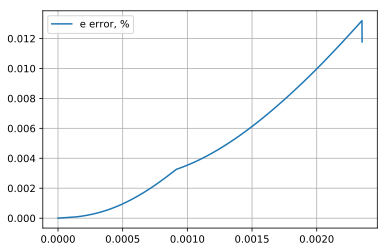

In [17]:
xs = [lr.time for lr in lrs]
epot = np.array([lr.get_E_potential() for lr in lrs])
ekinet =np.array([lr.get_E_kinetic()  for lr in lrs])
esum =np.array([(lr.get_E_sum() + b.mass*lr.Vs_borders[-1]**2/2-lrs[0].get_E_sum())/lrs[0].get_E_sum()*100  for lr in lrs])    
# plt.plot(xs, epot, label='epot')
# plt.plot(xs, ekinet, label='ekinet')
plt.plot(xs, esum, label='e error, %')
plt.legend()
plt.grid()
plt.show()

In [27]:
lrs1 = lrs

In [29]:
def get_v_d(Cq):
    gl = get_simple_gl()
    d = 23e-3
    q = Cq * (d*10)**3
    b = BorderSimple(gl, None, q, 0)
    vl = 0
    for i in range(100000):
        if gl.xs_borders[-1] > tube.get_xs()[-1]:
            break
        tau = gl.get_tau_min()*0.4
        b.update_xs()
        b.update_Vs(tau)
        gl = gl.step_up(tau, False)
        b.lr_left = gl
    return gl.Vs_borders[-1]

In [30]:
Cqs = np.linspace(0.1, 10, 100)
vds = [get_v_d(Cq) for Cq in Cqs]

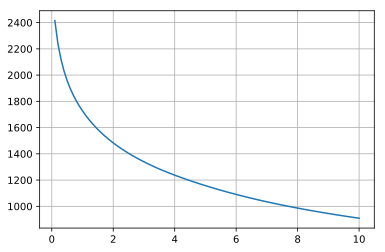

In [31]:
plt.plot(Cqs, vds)
plt.grid()
plt.show()

In [39]:
# cqs_vds = np.array([Cqs, vds])
# np.save('He_simple_p100', cqs_vds)

In [41]:
pi

3.141592653589793

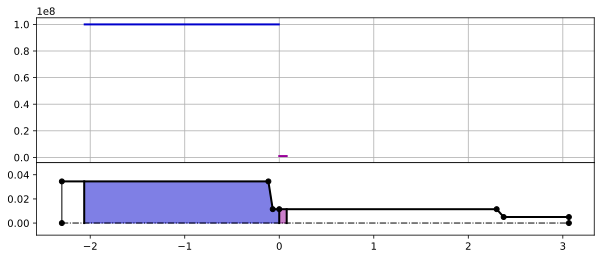

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=100.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':100000000.0, 'tau_min': 2.318405125018617e-07, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.00045999999999999514, 
        'x_1': -2.0633538038628103, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=157); 
        {'p_max':1000000.0, 'tau_min': 2.1678949029564129e-07, 
        'u_max': 0.0, 'cs_max': 2308.3844297415135, 'dx_min': 0.0005004334839300573, 
        'x_1': 0.0, 'x_2': 0.0785680569770193,
        'V_1':  0.0, 'V_2':  0.0  }

In [35]:

# sandwich_dict_sample = {
#     'tube': tube_dict,
#     'x_left': 0.1,
#     'layers': [
#         powder_layer_dict_sample,
#         {
#             'type': 'pist',
#             'omega': 0.05,  # кг
#             'p_0': 1e5, # начальное давление в полиэтилене
#             'u_0': 0,     #начальная скорость
#             'ElPistEOS_kwargs': dict(
#                 k=1.63098, 
#                 c_0=2308, 
#                 ro_0=919.03, 
#                 sigma_star=25.2, 
#                 k_0=0.054, 
#                 b_1=0.027, 
#                 b_2=0.00675, 
#                 tau_0=1.36, 
#                 mu=0.001, 
#                 tau_s=1,                 
#                 zeroP=False, 
#                 zeroE=False)
#         },
#         gas_layer_dict_sample,
        
#     ],
#     'borders': [
#         {
#             'mass': 1000, # kg
#             'p_f': 100000e6, #Pa
#             't_init': -1,
#             'w_border': 0.05, #m
#         },
#         {
#             'mass': 0.01, # kg
#             'p_f': 300e6, #Pa
#             't_init': -1,
#             'w_border': 0.005, #m
#         },
#         {
#             'mass': 0.01, # kg
#             'p_f': 300e6, #Pa
#             't_init': -1,
#             'w_border': 0.005, #m
#         },
#         {
#             'mass': 0.1, # kg
#             'p_f': 400e6, #Pa
#             't_init': -1,
#             'w_border': 0.01, #m
#         },
#     ],
#     'calc_settings': {
#         'powder_settings': {
#             'cell_dx': 0.0025,
#             'n_cells_min': 13,
#             'n_cells_max': 300,
#             'GasFluxCalculator_kwargs': {'flux_type':2},
#             'GridStrecher_kwargs': {}
#         },
#         'gas_settings': {
#             'cell_dx': 0.0025,
#             'n_cells_min': 13,
#             'n_cells_max': 300,
#             'GasFluxCalculator_kwargs': {'flux_type':2},
#             'GridStrecher_kwargs': {}
#         },
#         'pist_settings': {
#             'cell_dx': 0.0025,
#             'n_cells_min': 13,
#             'n_cells_max': 300,
#             'GasFluxCalculator_kwargs': {'flux_type':1},
#             'GridStrecher_kwargs': {}
#         }
#     }
# }

class Sandwich(object):
    @classmethod
    def get_sandw(cls, **kwargs):
#         tube_dict = {
#             'tube_points': [[-d*100,3*d],[-d*5,3*d],[-3*d,d],[0, d], [100*d, d]]
#         }
        alpha = kwargs.get('alpha', 15)*pi/180
        d2 = kwargs.get('d2', 10)/1000
        d = tube_dict['tube_points'][-1][1]
        l_cone = (d - d2)/2/tan(alpha)
        x2 = tube_dict['tube_points'][-1][0] + l_cone
        tube2_dict = {
            'tube_points': tube_dict['tube_points'] + [[x2, d2], [x2+30*d, d2]] 
        }
        tube = Tube.get_standart(tube2_dict)
        res = cls(tube)
        
        gl = get_simple_gl(tube=tube)
        res.layers.append(gl)
        q_pereg = kwargs.get('q_pereg', 100)/1000
        b99 = BorderSimple(None, None, 10000, 1e14)
        res.borders.append(b99)
        b1 = BorderSimple(None, None, q_pereg, 0)
        res.borders.append(b1)
        
        pist_omega = kwargs.get('pist_omega', 30)/1000
        pist_layer_dict = {
            'type': 'pist',
            'omega': pist_omega,  # кг
            'p_0': 1e6, # начальное давление в полиэтилене
            'u_0': 0,     #начальная скорость
            'ElPistEOS_kwargs': dict(
                k=1.63098, 
                c_0=2308, 
                ro_0=919.03, 
                sigma_star=25.2, 
                k_0=0.054, 
                b_1=0.027, 
                b_2=0.00675, 
                tau_0=1.36, 
                mu=0.001, 
                tau_s=1,                 
                zeroP=False, 
                zeroE=True)
        }
        calc_settings_pist = {
            'cell_dx': 0.0005,
        #     'n_cells': 600,
            'n_cells_min': 13,
            'n_cells_max': 300,
            'GasFluxCalculator_kwargs': {'flux_type':1},
            'GridStrecher_kwargs': {}
        }
        pist_lr = ElPistLayer.get_standart(tube, 0, pist_layer_dict, calc_settings_pist) 
        res.layers.append(pist_lr)
        
        Cq = kwargs.get('Cq', 1)
        q = Cq * (d*10)**3
        b = BorderSimple(None, None, q, 0)
        res.borders.append(b)
        res.connect_borders_layers()
        return res
        
                                     
    def __init__(self, tube: Tube, i=0):
        self.tube = tube
        self.i = i
        self.layers = []
        self.borders= []
        
    def connect_borders_layers(self):
        if len(self.layers)+1 != len(self.borders):
            raise AttributeError(f'Неправильное количество границ и слоев len(self.layers)={len(self.layers)}  len(self.borders)={len(self.borders)}')
        all_layers = [None] + self.layers + [None]
        for b, lr_left, lr_right in zip(self.borders, all_layers[:-1], all_layers[1:]):
            b.lr_left = lr_left
            b.lr_right = lr_right
        
    def simple_step(self, courant):
        tau = min([lr.get_tau_min() for lr in self.layers]) * courant
        for b in self.borders:
            b.update_xs()
        for b in self.borders:
            b.update_Vs(tau)
        result = Sandwich(self.tube, self.i+1)
        result.layers = [lr.step_up(tau) for lr in self.layers]
        result.borders= [b.copy() for b in self.borders]
        result.connect_borders_layers()
        return result
    
    def plot(self, fig, ax, **kwargs):
        self.tube.plot(fig, ax, **kwargs)
        for lr in self.layers:
            lr.plot(fig, ax, **kwargs)
        for b in self.borders:
            b.plot(fig, ax, **kwargs)
            
    def plot_param(self, fig, ax, param_name, **kwargs):
        for lr in self.layers:
            xs = np.array(lr.xs_cells)
            ys = np.array(getattr(lr, param_name))
            color = lr.color_4_plot
            lw = kwargs.get('lw', 2)
            ax.plot(xs, ys, color=color, lw=lw)
            
    def get_t(self):
        ts = [lr.time for lr in self.layers]
        if abs(min(ts) - max(ts)) > 1e-14:
            print(f'Слои не синхронизированны {ts}')
        return ts[0]
    
    def get_vel(self):
        return self.layers[-1].Vs_borders[-1]
    
    def get_x_projectile(self):
        return self.layers[-1].xs_borders[-1]

    
    def get_p_max(self):
        return max([np.max(lr.ps) for lr in self.layers])
    
    def __str__(self):
        res = f'Sandwich i={self.i}; t={self.get_t()*1000} ms;  vel={self.get_vel()} m/s;  p_max={self.get_p_max()*1e-6} MPa\nlayers:\n'
        for i, lr in enumerate(self.layers):
            res += f'{i}) {lr}\n'
        return res
    
    def __repr__(self):
        return str(self)
        
sandw = Sandwich.get_sandw(alpha=5)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ps')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.05)
# ax2.set_xlim(100*d-0.1,100*d+0.1)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw

In [36]:
history = [sandw]
for i in tqdm_notebook(range(150000)):
    if sandw.get_x_projectile() > sandw.tube.get_x_right():
        break
    if sandw.layers[-1].ps[-1] < -300e6:
        break
    sandw = sandw.simple_step(0.4)
    if i>0 and i % 25 == 0:
        history.append(sandw)
    else:
        history[-1] = sandw


In [37]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=1, value=len(history)-1))
def plotMe(ind):
    sandw = history[ind]

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    sandw.plot(fig, ax2)
    sandw.plot_param(fig, ax0, 'us')
    ax2.set_ylim(-0.01,0.04)
#     ax0.set_ylim(-1,1)
    ax1.grid(True)
    ax0.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()
    print(sandw)

interactive(children=(IntSlider(value=2314, description='ind', max=2314), Output()), _dom_classes=('widget-int…